<a href="https://colab.research.google.com/github/HebaSedik/deep-learning/blob/master/sentiment_analysis_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***dataset***
https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

# ***load & pre-process data***

In [5]:
movie_reviews = pd.read_csv("/content/IMDBDataset.csv")
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [6]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
movie_reviews["review"][4]

'Petter Mattei\'s "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler\'s play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case wit

<Axes: xlabel='sentiment', ylabel='count'>

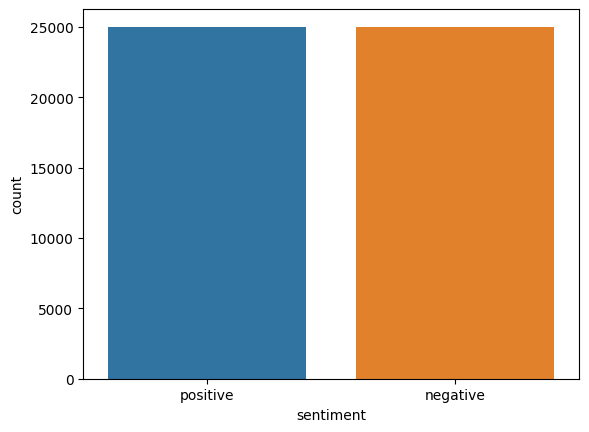

In [8]:
import seaborn as s
s.countplot(x='sentiment', data=movie_reviews)

# **data preprocessing and cleaning**

In [9]:
def preprocess_text(sen):
  # Removing html tags
  sentence = remove_tags(sen)
  # Remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)
  return sentence

In [10]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
  return TAG_RE.sub('', text)

In [11]:
review = []
sentences = list(movie_reviews['review'])
for sen in sentences:
  review.append(preprocess_text(sen))

In [12]:
review[4]

'Petter Mattei Love in the Time of Money is visually stunning film to watch Mr Mattei offers us vivid portrait about human relations This is movie that seems to be telling us what money power and success do to people in the different situations we encounter This being variation on the Arthur Schnitzler play about the same theme the director transfers the action to the present time New York where all these different characters meet and connect Each one is connected in one way or another to the next person but no one seems to know the previous point of contact Stylishly the film has sophisticated luxurious look We are taken to see how these people live and the world they live in their own habitat The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits big city is not exactly the best place in which human relations find sincere fulfillment as one discerns is the case with most of the people we encounter The acting is good under

# **convert labels into integers**

In [13]:
converted = movie_reviews['sentiment']
converted = np.array(list(map(lambda x: 1 if x=="positive" else 0, converted)))

# **divide dataset into train and test sets**

In [14]:
review_train, review_test, converted_train, converted_test = train_test_split(review, converted, test_size=0.20, random_state=42)

In [15]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)
review_train = tokenizer.texts_to_sequences(review_train)
review_test = tokenizer.texts_to_sequences(review_test)

# **padding "max size = 100 , add 0 at the end of list untill it reaches max length"**

In [16]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
review_train = pad_sequences(review_train, padding='post', maxlen=maxlen)
review_test = pad_sequences(review_test, padding='post', maxlen=maxlen)

## **glove embedding**

https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt

In [17]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dictionary [word] = vector_dimensions
glove_file.close()

# **create embedding matrix**

In [18]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

# **building and training model**

In [19]:
from keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9254700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9372077 (35.75 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9254700 (35.30 MB)
_________________________________________________________________


In [21]:
history = model.fit(review_train, converted_train,batch_size=128,epochs=6,verbose=1, validation_split=0.2)
score=model.evaluate(review_test, converted_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 86s 335ms/step - loss: 0.5495 - acc: 0.7154 - val_loss: 0.4572 - val_acc: 0.7844
Epoch 2/6
250/250 [==============================] - 83s 333ms/step - loss: 0.4606 - acc: 0.7823 - val_loss: 0.4168 - val_acc: 0.8114
Epoch 3/6
250/250 [==============================] - 89s 356ms/step - loss: 0.4081 - acc: 0.8148 - val_loss: 0.3958 - val_acc: 0.8144
Epoch 4/6
250/250 [==============================] - 95s 381ms/step - loss: 0.3811 - acc: 0.8303 - val_loss: 0.3667 - val_acc: 0.8361
Epoch 5/6
250/250 [==============================] - 87s 348ms/step - loss: 0.3549 - acc: 0.8437 - val_loss: 0.3721 - val_acc: 0.8292
Epoch 6/6
313/313 [==============================] - 17s 54ms/step - loss: 0.3428 - acc: 0.8496


In [22]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3427945375442505
Test Accuracy: 0.8496000170707703


# **make predictions**

In [23]:
instance = review[60]
print(instance)

What happened What we have here is basically solid and plausible premise and with decent and talented cast but somewhere the movie loses it Actually it never really got going There was little excitement when we find out that Angie is not really pregnant then find out that she is after all but that was it Steve Martin who is very talented person and usually brings lot to movie was dreadful and his entire character was not even close to being important to this movie other than to make it longer really would have liked to see more interactions between the main characters Kate and Angie and maybe try not for pure comedy which unfortunately it was not but maybe drama with comedic elements think if the movie did this it could have been very funny since both actresses are quite funny in their own ways and sitting here can think of numerous scenarios that would have been riot 


# **review into numeric**

# negative if value less thain 0.5

In [24]:
instance = tokenizer.texts_to_sequences(instance)
flat_list = []
for sublist in instance:
  for item in sublist:
    flat_list.append(item)
flat_list = [flat_list]
instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)
model.predict(instance)

1/1 [==============================] - 0s 493ms/step


array([[0.81576926]], dtype=float32)

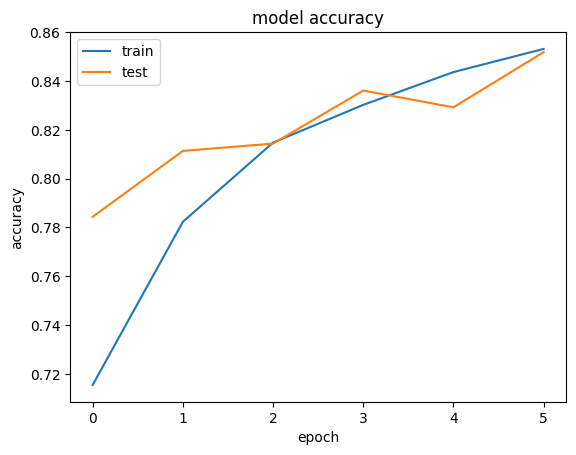

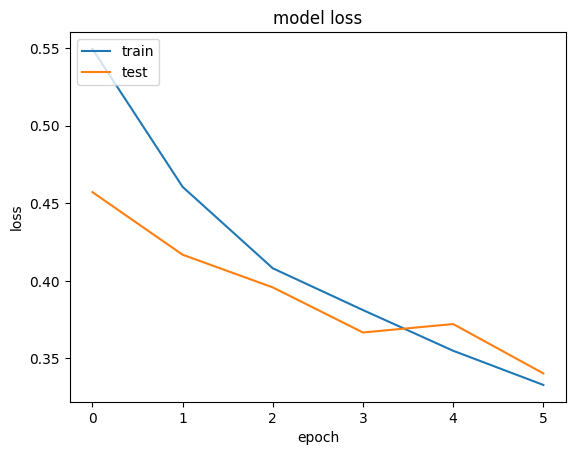

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()